In [1]:
import pickle
import pandas as pd
import sqlite3
from model_utils import prepare_df
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
conn = sqlite3.connect('../data/data_for_ml.db')
df = pd.read_sql('SELECT * FROM messages', con=conn)
conn.close()
df_train, df_test, cols = prepare_df(df)

In [3]:
model_files = [
    'model_baseline_notuning_at_all.pickle',
    'test_preprocess.pickle',
    'model_individual.pickle',
    'model_individual_stack.pickle'
]

In [4]:
models = []
for model_file in model_files:
    print(model_file)
    with open(model_file, 'rb') as fid:
        models.append(pickle.load(fid))
    print(f1_score(models[-1].predict(df_test), df_test[cols].values, average='macro'))

model_baseline_notuning_at_all.pickle
0.18105355693635647
test_preprocess.pickle
0.4727914245761501
model_individual.pickle
0.48305306281277205
model_individual_stack.pickle
0.48411939503857215


In [5]:
result = pd.DataFrame(columns=cols)
y_true = df_test[cols].values
for model in models:
    y_pred = model.predict(df_test)
    scores = [f1_score(y_pred[:,i], y_true[:,i]) for i in range(len(cols))]
    result.loc[len(result)] = scores

In [6]:
result['model'] = ['no_fitting','tuning','individual','stack']
result

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,...,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,model
0,0.887349,0.584320,0.000000,0.700475,0.070640,0.074349,0.000000,0.000000,0.000000,0.338308,...,0.000000,0.699147,0.258197,0.313793,0.000000,0.611961,0.017857,0.020202,0.526245,no_fitting
1,0.863381,0.656546,0.000000,0.734451,0.513200,0.484305,0.423237,0.120805,0.550649,0.675610,...,0.284501,0.768918,0.641054,0.685315,0.475248,0.808642,0.553571,0.356564,0.623838,tuning
2,0.889182,0.680265,0.181818,0.731178,0.508368,0.506616,0.373832,0.166667,0.543011,0.707152,...,0.299301,0.780000,0.665829,0.700093,0.458716,0.818947,0.563877,0.355263,0.636077,individual
3,0.887750,0.688347,0.080000,0.737946,0.506958,0.458167,0.362319,0.151111,0.574413,0.690382,...,0.277778,0.774800,0.643392,0.701754,0.531915,0.813142,0.525822,0.366972,0.635496,stack


In [7]:
tmp = result.set_index('model').stack().reset_index()
tmp.columns = ['model','category','f1_score']
tmp

,model,category,f1_score
0,no_fitting,related,0.887349
1,no_fitting,request,0.584320
2,no_fitting,offer,0.000000
3,no_fitting,aid_related,0.700475
4,no_fitting,medical_help,0.070640
...,...,...,...
135,stack,fire,0.531915
136,stack,earthquake,0.813142
137,stack,cold,0.525822
138,stack,other_weather,0.366972


<Axes: xlabel='f1_score', ylabel='category'>

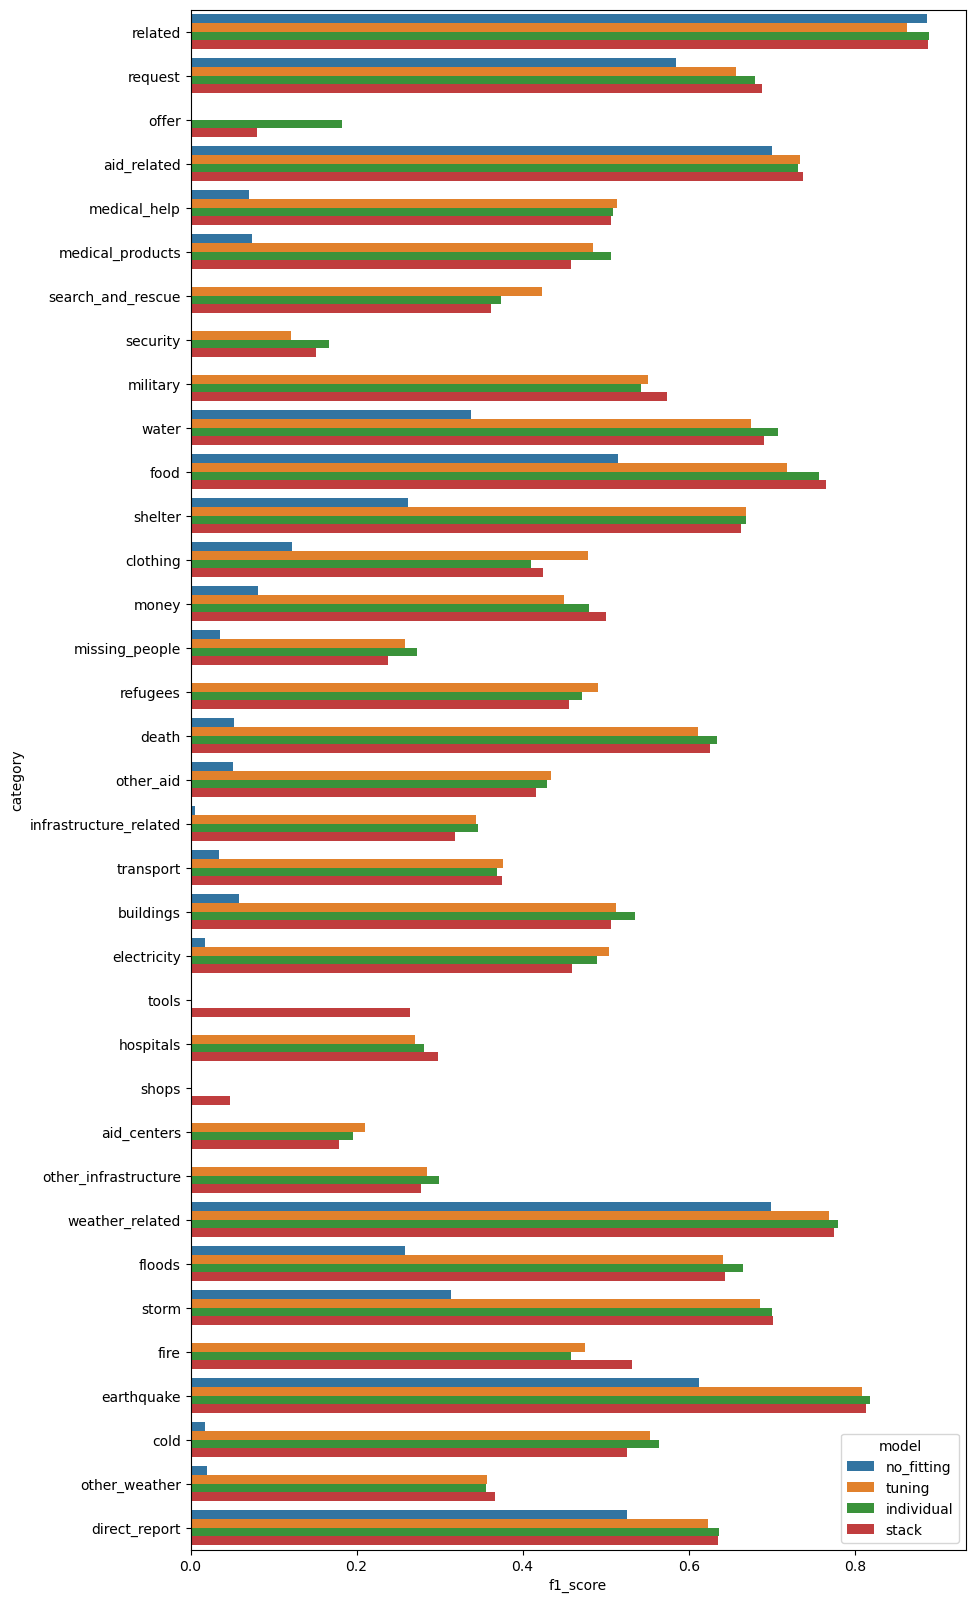

In [8]:
fig, ax = plt.subplots(figsize=(10,20))
sns.barplot(tmp, x='f1_score', y='category', hue='model', ax=ax)